<a href="https://colab.research.google.com/github/HaJunYoo/Pyspark-tutorial/blob/main/taxi_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Spark 세팅 및 실습 데이터 준비

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop2.tgz
!tar -xvf spark-3.3.1-bin-hadoop2.tgz
!pip install -q findspark
!pip install pyspark

spark-3.3.1-bin-hadoop2/
spark-3.3.1-bin-hadoop2/LICENSE
spark-3.3.1-bin-hadoop2/NOTICE
spark-3.3.1-bin-hadoop2/R/
spark-3.3.1-bin-hadoop2/R/lib/
spark-3.3.1-bin-hadoop2/R/lib/SparkR/
spark-3.3.1-bin-hadoop2/R/lib/SparkR/DESCRIPTION
spark-3.3.1-bin-hadoop2/R/lib/SparkR/INDEX
spark-3.3.1-bin-hadoop2/R/lib/SparkR/Meta/
spark-3.3.1-bin-hadoop2/R/lib/SparkR/Meta/Rd.rds
spark-3.3.1-bin-hadoop2/R/lib/SparkR/Meta/features.rds
spark-3.3.1-bin-hadoop2/R/lib/SparkR/Meta/hsearch.rds
spark-3.3.1-bin-hadoop2/R/lib/SparkR/Meta/links.rds
spark-3.3.1-bin-hadoop2/R/lib/SparkR/Meta/nsInfo.rds
spark-3.3.1-bin-hadoop2/R/lib/SparkR/Meta/package.rds
spark-3.3.1-bin-hadoop2/R/lib/SparkR/NAMESPACE
spark-3.3.1-bin-hadoop2/R/lib/SparkR/R/
spark-3.3.1-bin-hadoop2/R/lib/SparkR/R/SparkR
spark-3.3.1-bin-hadoop2/R/lib/SparkR/R/SparkR.rdb
spark-3.3.1-bin-hadoop2/R/lib/SparkR/R/SparkR.rdx
spark-3.3.1-bin-hadoop2/R/lib/SparkR/help/
spark-3.3.1-bin-hadoop2/R/lib/SparkR/help/AnIndex
spark-3.3.1-bin-hadoop2/R/lib/SparkR/h

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop2"

In [4]:
# need to update-alternatives
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [5]:
!java -version

openjdk version "1.8.0_352"
OpenJDK Runtime Environment (build 1.8.0_352-8u352-ga-1~20.04-b08)
OpenJDK 64-Bit Server VM (build 25.352-b08, mixed mode)


In [6]:
import findspark
findspark.init()

In [7]:
path = '/content/drive/MyDrive/Spark/01-spark'

- https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page <br>
- yellow_tripdata_2021-01 ~ 07까지 다운받아 parquet을 csv로 변환
  - colab 환경에서는 pyspark로 parquet을 읽어오는데 문제 발생
  - yellow trip data는 시에서 운영하는 택시 데이터이므로 데이터가 조금 더 많다는 장점 존재


In [17]:
import pandas as pd

trip_files_path = path + "/data/trips/"
for i in range(1, 8):
  df = pd.read_parquet(trip_files_path + f'yellow_tripdata_2021-0{i}.parquet')
  df.to_csv(trip_files_path+f'yellow_tripdata_2021-0{i}.csv')

## Analysis start

In [8]:
from pyspark.sql import SparkSession

In [9]:
spark = SparkSession.builder.appName("taxi-analysis").getOrCreate()

In [10]:
trip_files = path + "/data/trips/*" 
# 파일 모두 선택 
zone_file = path + "/data/taxi+_zone_lookup.csv"

In [11]:
trips_df = spark.read.csv(f"file:///{trip_files}", inferSchema=True, header=True)
zone_df = spark.read.csv(f"file:///{zone_file}", inferSchema=True, header=True)

In [12]:
trips_df.printSchema()
zone_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-

In [13]:
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

In [14]:
# zone과 trip 데이터를 조인해서 dataframe을 새로 생성
query = """
SELECT 
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
FROM 
    trips t
    LEFT JOIN 
        zone pz
    ON
        t.PULocationID = pz.LocationID
    LEFT JOIN
        zone dz
    ON 
        t.DOLocationID = dz.LocationID
"""
## trip 데이터를 하나도 잃지 않기 위해서 zone을 left join 시킨다

## 쿼리를 통해 데이터 프레임을 만든 후 tempview 생성
comb_df = spark.sql(query)
comb_df.createOrReplaceTempView("comb")

In [15]:
comb_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [16]:
spark.sql("SELECT pickup_date, pickup_time from comb WHERE pickup_time > 0").show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2021-01-31|         23|
| 2021-01-31|         23|
| 2021-01-31|         23|
| 2021-01-31|         23|
| 2021-01-31|         23|
| 2021-01-31|         23|
| 2021-01-31|         23|
| 2021-02-01|         22|
| 2021-01-31|         23|
| 2021-02-01|          1|
| 2021-02-01|          1|
| 2021-02-01|          1|
| 2021-02-01|          1|
| 2021-02-01|          1|
| 2021-02-01|          1|
| 2021-02-01|          1|
| 2021-02-01|          1|
| 2021-02-01|          1|
| 2021-02-01|          1|
| 2021-02-01|          1|
+-----------+-----------+
only showing top 20 rows



In [17]:
# 데이터 클리닝 과정이 필요
spark.sql("SELECT pickup_date, pickup_time from comb WHERE pickup_date < '2020-12-31'").show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          1|
| 2009-01-01|         17|
| 2009-01-01|         17|
| 2009-01-01|         18|
| 2009-01-01|          1|
| 2009-01-01|          1|
| 2009-01-01|          2|
| 2009-01-01|          2|
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2009-01-01|          0|
+-----------+-----------+
only showing top 20 rows



In [18]:
# spark dataframe -> describe
comb_df.select("total_amount").describe().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|          15000936|
|   mean|18.755400511168382|
| stddev| 145.7431021908604|
|    min|            -647.8|
|    max|          398469.2|
+-------+------------------+



In [19]:
comb_df.select("trip_distance").describe().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15000936|
|   mean|6.628556730060037|
| stddev|671.7240645480967|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+



In [20]:
comb_df.select("passenger_count").describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          14166908|
|   mean|1.4253582362502812|
| stddev|1.0443336003189245|
|    min|               0.0|
|    max|               9.0|
+-------+------------------+



In [25]:
query = """
SELECT
     DATE_TRUNC('MM', c.pickup_date) AS month,
     COUNT(*) AS trips
FROM
    comb c
GROUP BY
    month
ORDER BY
    month desc
"""
spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      5|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|     36|
|2021-07-01 00:00:00|2821661|
|2021-06-01 00:00:00|2834204|
|2021-05-01 00:00:00|2507075|
|2021-04-01 00:00:00|2171215|
|2021-03-01 00:00:00|1925130|
|2021-02-01 00:00:00|1371689|
|2021-01-01 00:00:00|1369753|
|2020-12-01 00:00:00|     16|
|2009-01-01 00:00:00|    111|
|2008-12-01 00:00:00|     26|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      1|
|2002-12-01 00:00:00|      1|
+-------------------+-------+



In [26]:
# Data Clearing
query = """
SELECT
    *
FROM 
    comb c
WHERE
    c.total_amount < 5000
    AND c.total_amount > 0
    AND c.trip_distance < 100
    AND c.passenger_count < 4
    AND c.pickup_date >= '2021-01-01'
    AND c.pickup_date < '2021-08-01'
"""
cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView("cleaned")

In [23]:
cleaned_df.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+
|summary|         vendor_id|       pickup_time|     dropoff_time|   passenger_count|     trip_distance|       fare_amount|        tip_amount|       tolls_amount|      total_amount|       payment_type|         pickup_zone|        dropoff_zone|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+
|  count|          13297341|          13297341|         13297341|          13297341|          13297341|          13297341|          13297341|           13297341|          13297341|           13297341|            13297341|            13297341|
|   mean|1.6708780349394665|

## spark -> pandas dataframe 시각화

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [27]:
query = """
SELECT 
    c.pickup_date,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date
"""
# 데이터 추출하여 pandas dataframe으로 변환 
pd_df = spark.sql(query).toPandas()

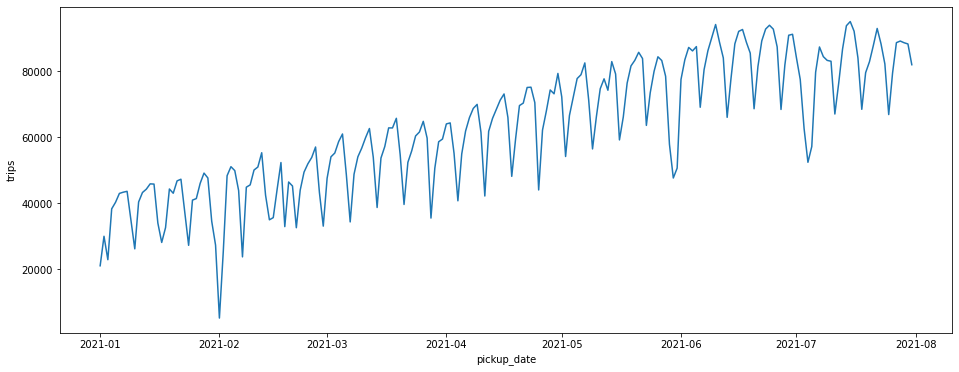

In [28]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x="pickup_date", y="trips", data=pd_df)

In [29]:
# 요일별로 trip 데이터를 보기
query = """
SELECT 
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date,
    day_of_week
"""
pd_df2 = spark.sql(query).toPandas()

In [30]:
data = pd_df2.groupby("day_of_week").trips.median().to_frame().reset_index()
data["sort_dow"] = data["day_of_week"].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
})

In [31]:
data.sort_values(by="sort_dow", inplace=True)

In [33]:
data

,day_of_week,trips,sort_dow
3,Sunday,43131.0,0
1,Monday,56063.0,1
5,Tuesday,66821.0,2
6,Wednesday,69398.5,3
4,Thursday,72190.5,4
0,Friday,73094.0,5
2,Saturday,61471.0,6


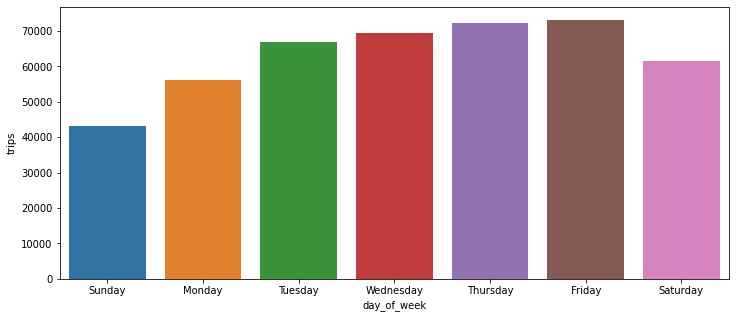

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(
    x="day_of_week",
    y="trips",
    data=data
)

In [34]:
def get_weekday(data):
    import calendar
    return calendar.day_name[date.weekday()]

spark.udf.register("get_weekday", get_weekday)

<function __main__.get_weekday(data)>

In [35]:
## udf를 활용한 query 문
query = """
SELECT 
    c.pickup_date,
    get_weekday(c.pickup_date) AS day_of_week,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date,
    day_of_week
"""


In [36]:
payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip",
}
def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]

spark.udf.register("parse_payment_type", parse_payment_type)

<function __main__.parse_payment_type(payment_type)>

In [37]:
# 위에서 만든 udf 함수 2개를 활용하여 쿼리 실행 
query = """
SELECT 
    parse_payment_type(payment_type), 
    count(*) AS trips,
    MEAN(fare_amount) AS mean_fare_amount,
    STD(fare_amount) AS stdev_fare_amount
FROM
    cleaned
GROUP BY
    payment_type
"""

spark.sql(query).show()

+--------------------------------+--------+------------------+------------------+
|parse_payment_type(payment_type)|   trips|  mean_fare_amount| stdev_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|10118059|12.216703494217713|10.795006823047487|
|                       No Charge|   58554|11.930768862929945|15.037653917600062|
|                         Dispute|   23540|12.652123194562444|14.162625766142915|
|                            Cash| 3097187|  11.9810152050877|11.474080178274468|
|                         Unknown|       1|              17.8|              null|
+--------------------------------+--------+------------------+------------------+

